# CIFAR10 with Transfer Learning

In [1]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.noise import GaussianNoise
from keras.layers.normalization import BatchNormalization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, pickle
from keras.utils import to_categorical
%matplotlib inline

Using TensorFlow backend.


## 1. Load Pre-trained Model

keras 提供了很方便的预训练模型库，可以通过 `keras.applications` 模块访问到。

- 在创建模型对象时，会自动检查本地是否已经有下载好的模型（h5格式），如果没有，会自动从Github上下载。（默认地址为 `~/.keras/models`）
- 每个模型都分两个版本：
    - 一种是文件名中带 `notop` 字段的模型，这种模型只含卷积层，不含全连接层，因此仅能用于特征识别，需要自己额外训练分类器。
        > `vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5`
    - 一种则是既带卷积层又带全连接层的完整模型版本，可以直接拿过来对新图像进行识别分类。
        > `vgg16_weights_tf_dim_ordering_tf_kernels.h5`

### 1.1 Load the Entire Model (CONV + FC)

随便找了一张几年前在新天鹅堡拍的照片，直接送入经过ImageNet数据集训练的VGG16完整模型。

可以看到，几乎不费吹灰之力，就能准确的预测出所属类别：`castle`。相当感人。

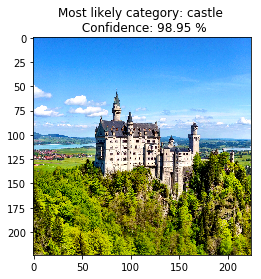

[[('n02980441', 'castle', 0.98945051),
  ('n03877845', 'palace', 0.0056559043),
  ('n03781244', 'monastery', 0.0041063223),
  ('n03028079', 'church', 0.00017413322),
  ('n09468604', 'valley', 0.00013395882)]]

In [5]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image

base_model = VGG16(weights='imagenet')
img = image.load_img('castle.jpg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y_pred = base_model.predict(x)
result = decode_predictions(y_pred, top=5)
plt.imshow(img, cmap='gray')
plt.title("Most likely category: %s \n Confidence: %.2f %%" % (result[0][0][1], result[0][0][2] * 100))
plt.show()
result

### 1.2 用ImageNet训练过的VGG16模型直接对我的Instagram照片库进行识别

可以看到，虽然预训练的模型已经经过ImageNet考验，但是对于**从未见过的图片类型**还是识别的令人哭笑不得。

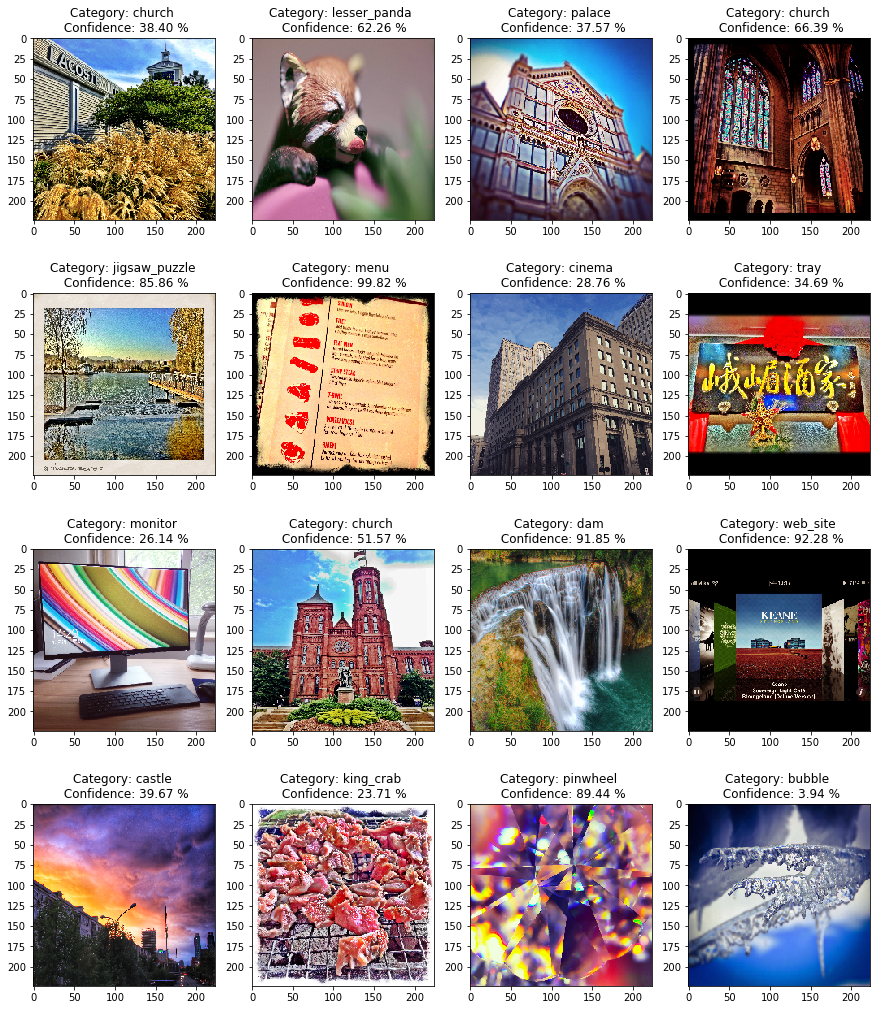

In [11]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import os

base_model = VGG16(weights='imagenet')
instagram_path = 'D:\\PythonWorkSpace\\InstagramDB\\'
files = [filename for filename in os.listdir(instagram_path)]
n = 16
rand_id = np.random.choice(range(len(files)), n)
plt.figure(figsize=(15, 18))
for i in range(n):
    plt.subplot(4, 4, i+1)
    img = image.load_img(instagram_path + files[rand_id[i]], target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    y_pred = base_model.predict(x)
    result = decode_predictions(y_pred, top=5)
    plt.imshow(img, cmap='gray')
    plt.title("Category: %s \n Confidence: %.2f %%" % (result[0][0][1], result[0][0][2] * 100))
plt.show()

### 1.3 直接用基于ImageNet训练的VGG16模型对CIFAR10图片集进行预测

- #### 可以看到，由于两个图片集的差别很大，因此原封不动直接拿来预测的结果基本没法看。
    
    - **类别不同**：ImageNet有1000类图片，CIFAR10只有10类，
    - **图片质量不同**：ImageNet分辨率有224x224，CIFAR10只有可怜的 32x32

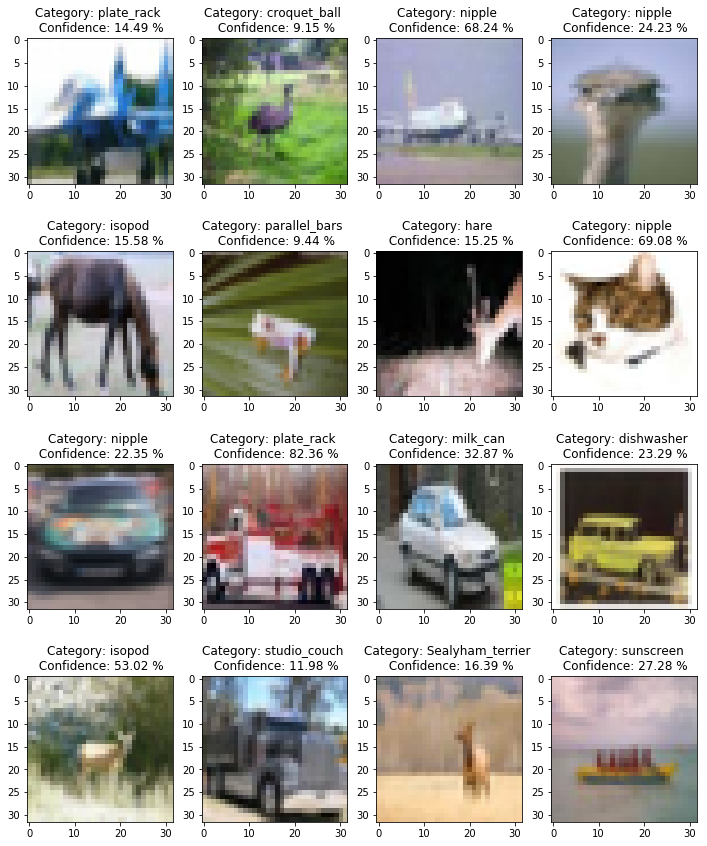

In [9]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import os
import cv2

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])

base_model = VGG16(weights='imagenet')
n = 16
rand_id = np.random.choice(range(50000), n)
plt.figure(figsize=(12, 15))
for i in range(n):
    plt.subplot(4, 4, i+1)
    img = X_train[rand_id[i]]
    x = cv2.resize(img, (224, 224))
    x = np.expand_dims(x, axis=0)
    y_pred = base_model.predict(x)
    result = decode_predictions(y_pred, top=5)
    plt.imshow(img, cmap='gray')
    plt.title("Category: %s \n Confidence: %.2f %%" % (result[0][0][1], result[0][0][2] * 100))
plt.show()

## 2. Transfer Learning

首先让我们尝试保持原模型卷积层部分参数不变，添加新的全连接层并训练的效果。

虽然我们可以直接用Keras提供的预训练模型对新数据集进行预测，但是这仅适用于新数据集的图像类别是原数据集图像类别的子集的情况。一旦新的数据集有模型之前从未见过的图像类别，那么是不可能预测准确的。这时候就需要我们对模型最后部分的Classifier用新数据集进行训练才行了。

In [19]:
base_model = VGG16(weights='imagenet', include_top=False)

# 卷积层输出的特征图作为输入
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)
y = Dense(10, activation='softmax', kernel_initializer='he_normal')(x)
model = Model(inputs=base_model.input, outputs=y, name='Transfer_Learning')

# Transfer Learning, FREEZE all layers in base_model
for layer in base_model.layers:
    layer.trainable = False
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

# Prepare Data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

- 如果仅添加全连接层并训练全连接层的话，即使带了数据增强，都只能收敛到 63% 准确率左右。

这说明仅仅训练Classifier还不够，需要对最后几个提取高层图像特征的卷积层也进行训练，以适应CIFAR10图片集的特征。

In [20]:
nb_epoch = 100
batch_size = 256
aug_gen = ImageDataGenerator(
    featurewise_center = False,  # set input mean to 0 over the dataset
    samplewise_center = False,  # set each sample mean to 0
    featurewise_std_normalization = False,  # divide inputs by std of the dataset
    samplewise_std_normalization = False,  # divide each input by its std
    zca_whitening = False,  # apply ZCA whitening
    rotation_range = 0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip = False,  # randomly flip images
)

aug_gen.fit(X_train)
gen = aug_gen.flow(X_train, y_train, batch_size=batch_size)

start = time.time()
h = model.fit_generator(generator=gen, steps_per_epoch=50000//batch_size, epochs=nb_epoch, validation_data=(X_test, y_test))

# h = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=nb_epoch, validation_data=(X_test, y_test), shuffle=True)
model.save('CIFAR10_Transfer_model.h5')
print('@ Total Time Spent: %.2f seconds' % (time.time() - start))

Epoch 1/100
195/195 [==============================] - 11s - loss: 1.7263 - acc: 0.3866 - val_loss: 1.4321 - val_acc: 0.5007
Epoch 2/100
195/195 [==============================] - 11s - loss: 1.4375 - acc: 0.4949 - val_loss: 1.3208 - val_acc: 0.5381
Epoch 3/100
195/195 [==============================] - 11s - loss: 1.3562 - acc: 0.5266 - val_loss: 1.2759 - val_acc: 0.5528
Epoch 4/100
195/195 [==============================] - 11s - loss: 1.3075 - acc: 0.5446 - val_loss: 1.2435 - val_acc: 0.5667
Epoch 5/100
195/195 [==============================] - 11s - loss: 1.2765 - acc: 0.5528 - val_loss: 1.2161 - val_acc: 0.5746
Epoch 6/100
195/195 [==============================] - 11s - loss: 1.2481 - acc: 0.5639 - val_loss: 1.2031 - val_acc: 0.5808
Epoch 7/100
195/195 [==============================] - 11s - loss: 1.2305 - acc: 0.5697 - val_loss: 1.1911 - val_acc: 0.5790
Epoch 8/100
195/195 [==============================] - 11s - loss: 1.2184 - acc: 0.5730 - val_loss: 1.1702 - val_acc: 0.5885


KeyboardInterrupt: 

In [ ]:
def plot_acc_loss(h, nb_epoch):
    acc, loss, val_acc, val_loss = h.history['acc'], h.history['loss'], h.history['val_acc'], h.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(nb_epoch), acc, label='Train')
    plt.plot(range(nb_epoch), val_acc, label='Test')
    plt.title('Accuracy over ' + str(nb_epoch) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(nb_epoch), loss, label='Train')
    plt.plot(range(nb_epoch), val_loss, label='Test')
    plt.title('Loss over ' + str(nb_epoch) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_acc_loss(h, nb_epoch)

## 3. Fine-Tuning

In [26]:
base_model = VGG16(weights='imagenet', include_top=False)

# 卷积层输出的特征图作为输入
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)
y = Dense(10, activation='softmax', kernel_initializer='he_normal')(x)
model = Model(inputs=base_model.input, outputs=y, name='Transfer_Learning')

In [27]:
base_model.layers[-4:]

In [28]:

# Fine-Tuning: Freeze the bottom part of CONV layer.
nb_freeze_layers = -4
for layer in base_model.layers[:nb_freeze_layers]:
    layer.trainable = False
for layer in base_model.layers[nb_freeze_layers:]:
    layer.trainable = True    
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

# Prepare Data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [30]:
nb_epoch = 100
batch_size = 256
aug_gen = ImageDataGenerator(
    featurewise_center = False,  # set input mean to 0 over the dataset
    samplewise_center = False,  # set each sample mean to 0
    featurewise_std_normalization = False,  # divide inputs by std of the dataset
    samplewise_std_normalization = False,  # divide each input by its std
    zca_whitening = False,  # apply ZCA whitening
    rotation_range = 0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip = False,  # randomly flip images
)

aug_gen.fit(X_train)
gen = aug_gen.flow(X_train, y_train, batch_size=batch_size)

start = time.time()
h = model.fit_generator(generator=gen, steps_per_epoch=50000//batch_size, epochs=nb_epoch, validation_data=(X_test, y_test))

# h = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=nb_epoch, validation_data=(X_test, y_test), shuffle=True)
model.save('CIFAR10_Transfer_model.h5')
print('@ Total Time Spent: %.2f seconds' % (time.time() - start))

Epoch 1/100
195/195 [==============================] - 12s - loss: 0.5454 - acc: 0.8303 - val_loss: 0.7972 - val_acc: 0.7518
Epoch 2/100
195/195 [==============================] - 11s - loss: 0.4459 - acc: 0.8520 - val_loss: 0.8211 - val_acc: 0.7511
Epoch 3/100
195/195 [==============================] - 11s - loss: 0.4078 - acc: 0.8624 - val_loss: 0.8064 - val_acc: 0.7586
Epoch 4/100
195/195 [==============================] - 11s - loss: 0.3705 - acc: 0.8754 - val_loss: 0.8352 - val_acc: 0.7571
Epoch 5/100
195/195 [==============================] - 11s - loss: 0.3444 - acc: 0.8833 - val_loss: 0.8072 - val_acc: 0.7676
Epoch 6/100
195/195 [==============================] - 11s - loss: 0.3227 - acc: 0.8902 - val_loss: 0.8213 - val_acc: 0.7655
Epoch 7/100
195/195 [==============================] - 11s - loss: 0.2930 - acc: 0.9005 - val_loss: 0.8167 - val_acc: 0.7690
Epoch 8/100
195/195 [==============================] - 11s - loss: 0.2842 - acc: 0.9027 - val_loss: 0.8840 - val_acc: 0.7644


KeyboardInterrupt: 